# Model Experimentation with Flowster Data
Note: the models still need fine tuning

### Data Importing and Cleaning

In [1]:
from rake_nltk import Rake
import re
import string
import pandas as pd

augmented_data = pd.read_csv('augmented_data_wcomment.csv')
raw_data = pd.read_csv('Flowster_Topic_Attributes_20200612000804.csv')

In [2]:
# Defined for cleaning text for train
def basic_data_processing(data, name_of_column):
    # Making words lowercase
    data[name_of_column] = data[name_of_column].apply(lambda x: str(x) if isinstance(x, float) else x.lower())
    # Remove punctuations from comments
    data[name_of_column] = data[name_of_column].str.replace('[^\w\s]','')
    # Remove stop words
    from sklearn.feature_extraction import text 
    stop_words = text.ENGLISH_STOP_WORDS
    data[name_of_column] = data[name_of_column].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [3]:
#data processing for augmented data
basic_data_processing(augmented_data, 'Leading Comment')
basic_data_processing(augmented_data, 'Topic Title')
augmented_data['Bag_of_words'] = augmented_data['Leading Comment'] + augmented_data['Topic Title']
augmented_data = augmented_data[['Category','Bag_of_words']]

#data processing for raw data
basic_data_processing(raw_data, 'Leading Comment')
basic_data_processing(raw_data, 'Topic Title')
basic_data_processing(raw_data, 'Other Comments')
raw_data['Bag_of_words'] = raw_data['Leading Comment'] + raw_data['Topic Title'] + raw_data['Other Comments']
raw_data = raw_data[['Category','Bag_of_words']]

In [4]:
#shows class imbalance in both augmented and raw data
#the imbalance seems even more serious in the augmented data than the raw one
import matplotlib.pyplot as plt

#raw
fig = plt.figure(figsize=(8,6))
raw_data.groupby('Category').Bag_of_words.count().plot.bar(ylim=0)
plt.show()

#augmented
fig = plt.figure(figsize=(8,6))
augmented_data.groupby('Category').Bag_of_words.count().plot.bar(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

<Figure size 800x600 with 1 Axes>

### Testing Model Accuracies
Code reference: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [5]:
#Tools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

#Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

#Putting the models into a list to be tested
#FINE TUNING NEEDED HERE!
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=51, max_iter=5, tol=None),
]

In [6]:
#Display Accuracy of the list of models
#Depends on what random_state is set to be, but it seems that LinearSVM and LineaerSVC are better
for model in models:
    model_name = model.__class__.__name__
    y = augmented_data['Category']
    X = augmented_data['Bag_of_words']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 51)
    
    sgd = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', model),
                   ])
    sgd.fit(X_train, y_train)

    y_pred = sgd.predict(X_test)

    print(model_name, 'accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))

RandomForestClassifier accuracy 0.47719298245614034
                        precision    recall  f1-score   support

       Amazon Specific       0.44      0.91      0.60        70
  Financial Management       0.00      0.00      0.00         5
     Flowster-specific       0.83      0.45      0.59        55
           Fulfillment       0.00      0.00      0.00        24
       Human Resources       0.00      0.00      0.00        33
            Management       0.00      0.00      0.00         8
           Misc Topics       0.00      0.00      0.00         8
      Product Sourcing       0.42      0.78      0.55        60
      Software & Tools       0.00      0.00      0.00        11
       Traffic Sources       0.00      0.00      0.00         7
eCommerce Marketplaces       0.00      0.00      0.00         4

              accuracy                           0.48       285
             macro avg       0.15      0.20      0.16       285
          weighted avg       0.36      0.48      0

/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
 

LogisticRegression accuracy 0.631578947368421
                        precision    recall  f1-score   support

       Amazon Specific       0.58      0.93      0.71        70
  Financial Management       0.00      0.00      0.00         5
     Flowster-specific       0.78      0.78      0.78        55
           Fulfillment       0.71      0.21      0.32        24
       Human Resources       0.89      0.48      0.63        33
            Management       1.00      0.25      0.40         8
           Misc Topics       0.00      0.00      0.00         8
      Product Sourcing       0.54      0.82      0.65        60
      Software & Tools       0.00      0.00      0.00        11
       Traffic Sources       0.00      0.00      0.00         7
eCommerce Marketplaces       0.00      0.00      0.00         4

              accuracy                           0.63       285
             macro avg       0.41      0.32      0.32       285
          weighted avg       0.60      0.63      0.57   

/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Generating Plots for Visualization of Accuracies

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

def plot_generator(data):
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
    features = tfidf.fit_transform(data.Bag_of_words).toarray()
    labels = data.Category

    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    
    entries = []
    for model in models:
      model_name = model.__class__.__name__
      accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    
    #Caculating the mean of all models
    print(cv_df.groupby('model_name').accuracy.mean())
    
    import seaborn as sns
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()

/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least popul

model_name
LinearSVC                 0.530929
LogisticRegression        0.507719
MultinomialNB             0.483223
RandomForestClassifier    0.295598
SGDClassifier             0.527763
Name: accuracy, dtype: float64


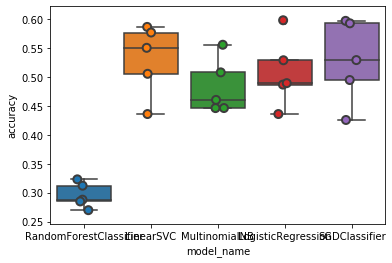

/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/kittyguz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least popul

model_name
LinearSVC                 0.515567
LogisticRegression        0.464238
MultinomialNB             0.473486
RandomForestClassifier    0.422727
SGDClassifier             0.453559
Name: accuracy, dtype: float64


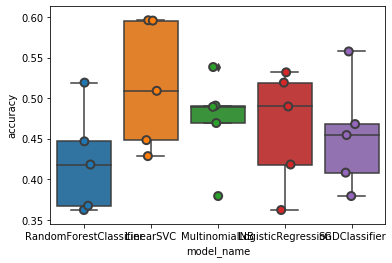

In [8]:
#plot for augmented data
plot_generator(augmented_data)

#plot for raw data
plot_generator(raw_data)